In [ ]:
# Adapted from https://keras.io/examples/vision/mnist_convnet/

In [257]:
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
plt.rc('font', **{'family':'normal', 'weight':'normal','size':21})

# Create DataFrame for Benford's Law Distribution & define helper functions

In [174]:
# create dataframe with benford's law distribution
benford = pd.DataFrame.from_dict({
    '1': 30.1,
    '2': 17.6,
    '3': 12.5,
    '4': 9.7,
    '5': 7.9,
    '6': 6.7,
    '7': 5.8,
    '8': 5.1,
    '9': 4.6
}, orient= 'index')
benford.columns = ['benford']

In [175]:
def get_leading_digit(x):
    '''
    Remove negative sign and get first non-zero digit (ignoring decimal) - used with dataframe of weight values to get their leading digit
    '''
    x = str(abs(x))
    if x[0] == '0':
        return str(int(x.split(".")[1]))[0]
    else:
        return x.split(".")[0]

In [241]:
def plot_benford_for_first_layer(title):
    
    # convert weights to dataframe
    leading_digits = pd.DataFrame(model.layers[0].get_weights()[0].flatten())
    leading_digits.columns = ['weight']
    leading_digits['leading_digit'] = leading_digits['weight'].apply(get_leading_digit)
    leading_digits = pd.DataFrame(100 * leading_digits['leading_digit'].value_counts()/len(leading_digits))

    # merge with benford's law distribution
    df = pd.merge(benford, leading_digits, left_index=True, right_index=True, how='left')
    df['deviation'] = df['leading_digit'] - df['benford']
    
    # plot
    print(df)
    df['abs_deviation'] = abs(df['deviation'])
    mad = round(df['abs_deviation'].mean(),2)
    print()
    print(f">>> Mean absolute deviation: {mad}")
    df[['leading_digit','benford']].plot(kind='bar', title=title +' (MAD=' + str(mad) + ')', figsize = (20,10), cmap="Accent")

In [253]:
def plot_benford_for_all_layers(title):
    # gather all weights in the model
    weights = []
    for layer in model.layers:
        if len(layer.get_weights()) > 0:
            weights.extend(layer.get_weights()[0].flatten())

    # convert weights to dataframe
    leading_digits = pd.DataFrame(weights)
    leading_digits.columns = ['weight']
    leading_digits['leading_digit'] = leading_digits['weight'].apply(get_leading_digit)
    leading_digits = pd.DataFrame(100 * leading_digits['leading_digit'].value_counts()/len(leading_digits))

    # merge with benford's law distribution
    df = pd.merge(benford, leading_digits, left_index=True, right_index=True, how='left')
    df['deviation'] = df['leading_digit'] - df['benford']

    # plot
    print(df)
    df['abs_deviation'] = abs(df['deviation'])
    mad = round(df['abs_deviation'].mean(),2)
    print()
    print(f">>> Mean absolute deviation: {round(df['abs_deviation'].mean(),2)}")
    df[['leading_digit','benford']].plot(kind='bar', title=title +' (MAD=' + str(mad) + ')', figsize = (20,10), cmap="Accent")

# Define Keras Model

In [259]:
# Model / data parameters
num_classes = 10
input_shape = (28, 28, 1)

# the data, split between train and test sets
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

# Scale images to the [0, 1] range
x_train = x_train.astype("float32") / 255
x_test = x_test.astype("float32") / 255
# Make sure images have shape (28, 28, 1)
x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)
print("x_train shape:", x_train.shape)
print(x_train.shape[0], "train samples")
print(x_test.shape[0], "test samples")


# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

x_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples


In [260]:
model = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(128, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Flatten(),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation="softmax"),
    ]
)

model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 26, 26, 64)        640       
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 13, 13, 64)        0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 11, 11, 128)       73856     
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 5, 5, 128)         0         
_________________________________________________________________
flatten_6 (Flatten)          (None, 3200)              0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 3200)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 10)               

In [228]:
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

In [193]:
model.fit(x_train, y_train, batch_size=128, epochs=15, validation_split=0.1)

Train on 54000 samples, validate on 6000 samples
Epoch 1/15
54000/54000 [==============================] - 66s 1ms/sample - loss: 0.2738 - acc: 0.9166 - val_loss: 0.0647 - val_acc: 0.9812
Epoch 2/15
54000/54000 [==============================] - 54s 1ms/sample - loss: 0.0838 - acc: 0.9735 - val_loss: 0.0526 - val_acc: 0.9850
Epoch 3/15
54000/54000 [==============================] - 56s 1ms/sample - loss: 0.0625 - acc: 0.9807 - val_loss: 0.0386 - val_acc: 0.9895
Epoch 4/15
54000/54000 [==============================] - 54s 995us/sample - loss: 0.0522 - acc: 0.9834 - val_loss: 0.0411 - val_acc: 0.9870
Epoch 5/15
54000/54000 [==============================] - 57s 1ms/sample - loss: 0.0437 - acc: 0.9858 - val_loss: 0.0340 - val_acc: 0.9915
Epoch 6/15
54000/54000 [==============================] - 70s 1ms/sample - loss: 0.0393 - acc: 0.9874 - val_loss: 0.0360 - val_acc: 0.9890
Epoch 7/15
54000/54000 [==============================] - 59s 1ms/sample - loss: 0.0365 - acc: 0.9884 - val_loss: 0

In [265]:
# model.save("trained_model.h5")
model = tf.keras.models.load_model("trained_model.h5")

In [195]:
score = model.evaluate(x_test, y_test, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

Test loss: 0.021814713062394003
Test accuracy: 0.9931


# Plot weight leading digit distribution vs. Benford's Law

## First layer only

   benford  leading_digit  deviation
1     30.1      12.326389 -17.773611
2     17.6      13.541667  -4.058333
3     12.5      10.243056  -2.256944
4      9.7      11.111111   1.411111
5      7.9       9.027778   1.127778
6      6.7      10.069444   3.369444
7      5.8      11.979167   6.179167
8      5.1      11.111111   6.011111
9      4.6      10.590278   5.990278

>>> Mean absolute deviation: 5.35


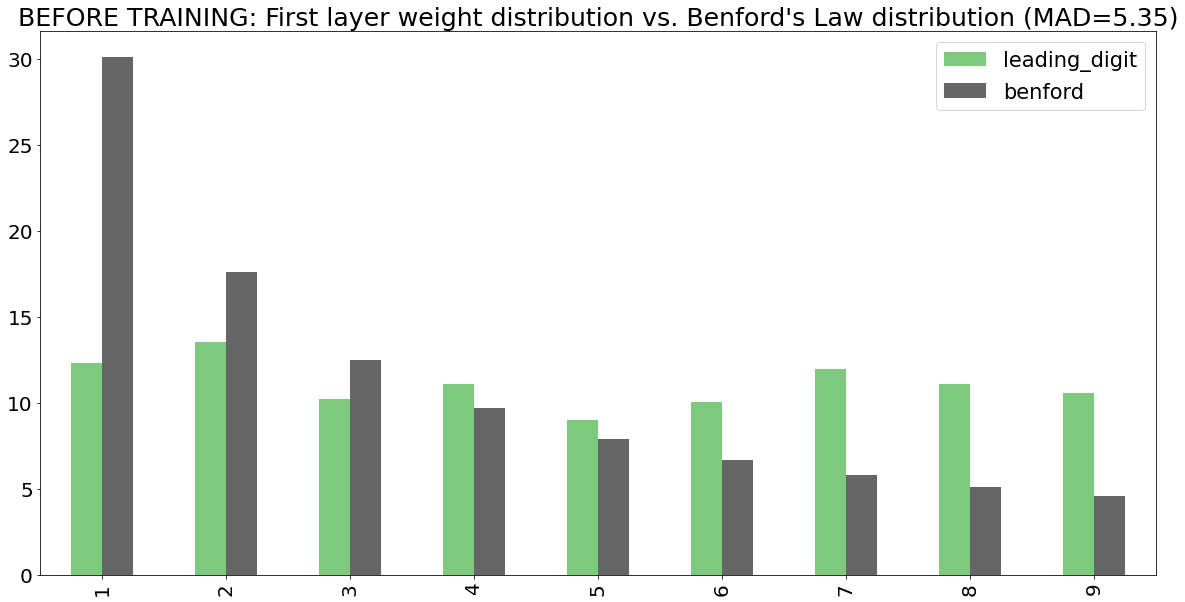

In [263]:
plot_benford_for_first_layer("BEFORE TRAINING: First layer weight distribution vs. Benford's Law distribution")

   benford  leading_digit  deviation
1     30.1      34.548611   4.448611
2     17.6      21.006944   3.406944
3     12.5      11.111111  -1.388889
4      9.7       7.812500  -1.887500
5      7.9       7.118056  -0.781944
6      6.7       4.513889  -2.186111
7      5.8       5.381944  -0.418056
8      5.1       5.208333   0.108333
9      4.6       3.298611  -1.301389

>>> Mean absolute deviation: 1.77


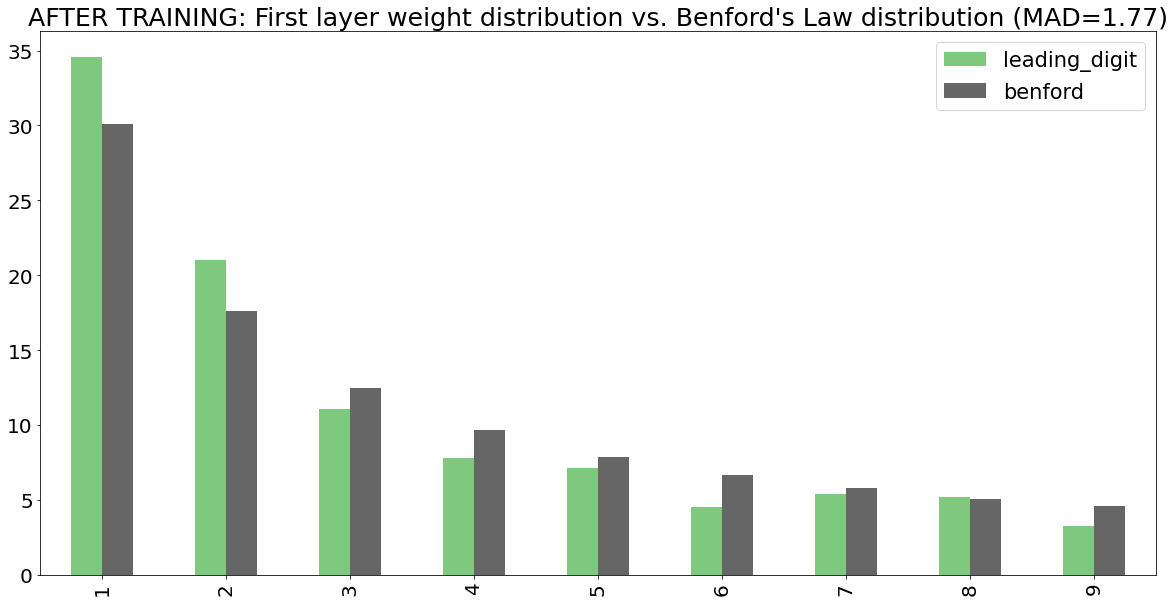

In [266]:
plot_benford_for_first_layer("AFTER TRAINING: First layer weight distribution vs. Benford's Law distribution")

## All layers

   benford  leading_digit  deviation
1     30.1      20.904199  -9.195801
2     17.6      21.030253   3.430253
3     12.5      20.855283   8.355283
4      9.7      16.254327   6.554327
5      7.9      12.422863   4.522863
6      6.7       2.176776  -4.523224
7      5.8       2.117512  -3.682488
8      5.1       2.145733  -2.954267
9      4.6       2.093054  -2.506946

>>> Mean absolute deviation: 5.08


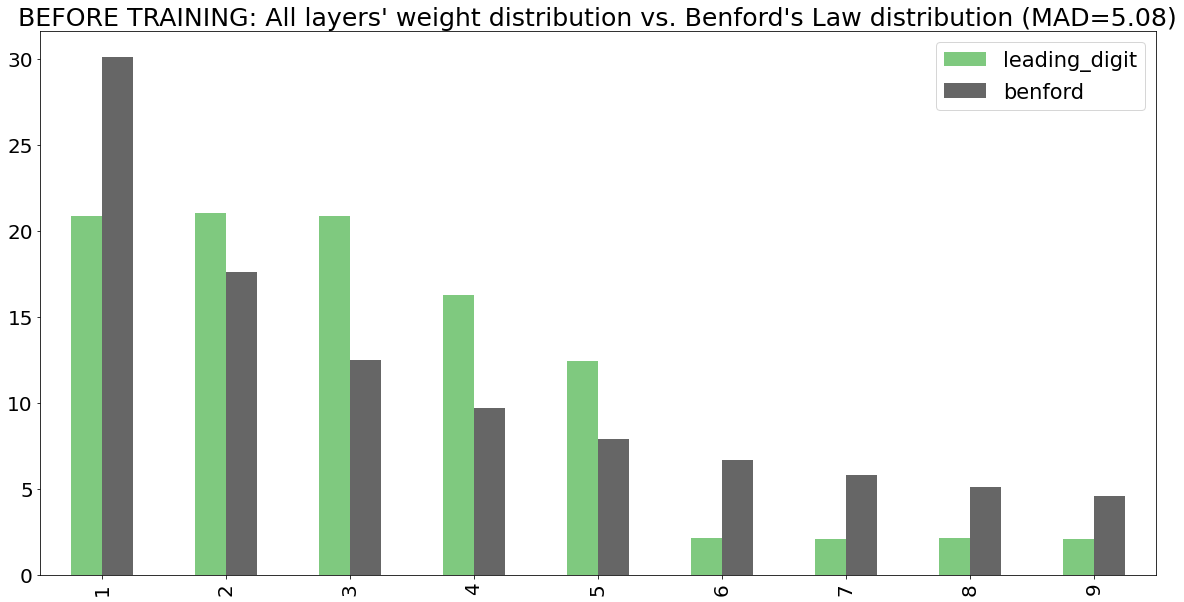

In [264]:
plot_benford_for_all_layers("BEFORE TRAINING: All layers' weight distribution vs. Benford's Law distribution")

   benford  leading_digit  deviation
1     30.1      31.125828   1.025828
2     17.6      14.019228  -3.580772
3     12.5      10.522652  -1.977348
4      9.7       9.293159  -0.406841
5      7.9       8.595161   0.695161
6      6.7       7.736303   1.036303
7      5.8       6.852047   1.052047
8      5.1       6.276340   1.176340
9      4.6       5.579282   0.979282

>>> Mean absolute deviation: 1.33


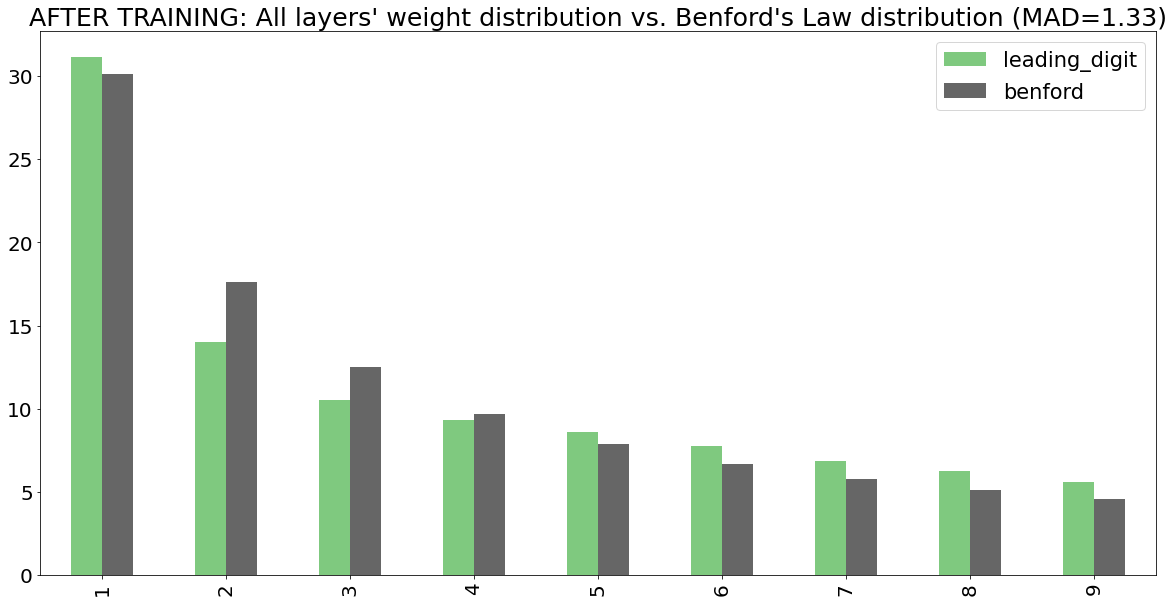

In [267]:
plot_benford_for_all_layers("AFTER TRAINING: All layers' weight distribution vs. Benford's Law distribution")